In [ ]:
from google.colab import drive
drive.mount('/content/d')

Mounted at /content/d


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

RANDOM_STATE = 42

## PREPROCESSING

**<ins>PROBLEM SETTING</ins>**: As the initial source we have the zip with the txt files 
already divided into the train and test split. Each file contains the the works of famous authors (Bradberry, Henry, Bulgakov...). Let's extract the zip into a single directory:

The txt files' names containt the reference - either it is the train or the test. So let's collect them into the separate lists: one for the all the texts labeled as train, the other one - as test.

In [ ]:
!unzip 'd/My Drive/nn/_4/Тексты писателей-20210525T170220Z-001.zip'

In [ ]:
def readText(fileName): 
    '''
    collect all the texts
    '''
    f = open(fileName, 'r')
    text = f.read()
    text = text.replace('\n', ' ')

    return text

# define the labels
labels = ['О. Генри', 'Стругацкие', 'Булгаков', 'Саймак', 'Фрай', 'Брэдберри']
nLabels = len(labels)

inputFolder = 'Тексты писателей/'

def collectTexts(inputFolder=inputFolder):
    '''
    collect all texts into the train and test smaples
    '''
    trainText, testText = [], []
    for label in labels:
        for fileName in os.listdir(inputFolder):
            if label in fileName:
                if 'Обучающая' in fileName:
                    trainText.append(readText(inputFolder + fileName))
                    print(f'{fileName} added to the train sample')
                if 'Тестовая' in fileName:
                    testText.append(readText(inputFolder+fileName))
                    print(f'{fileName} added to the test sample')

    return trainText, testText

trainText, testText = collectTexts()

The important step to pass the text to the model is to correctly convert it to the numerics. That can be performed in several steps:

**STEP 1:** word tokenization

We need to split our texts into the single words array and fit the tokenizer based on it.

In [ ]:
# to speed up the model fit and reduce RAM usage
maxWordsCount = 20000

# all the symbols to exclude from the processed text
symbolsToFilter = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff'

# tensorflow.keras.preprocessing.text
tokenizer = Tokenizer(
    num_words = maxWordsCount, # max words to be processed by the model
    filters = symbolsToFilter,
    lower = True, # enforce the lower register
    split = ' ', # split by space
    oov_token = 'unknown', # replaces all out-of-vocabulary words
    char_level = False # if True, every charcter is used as token
)

tokenizer.fit_on_texts(trainText)
items = list(tokenizer.word_index.items())

# check the input and the output
print(f'top 10 frequent words:\n{items[-10:]}')
print()
print(f'vocabulary size: {len(items)}')

**STEP 2:** convert tokens into the numeric sequence

We call the *fit_on_sequence* method for our tokenizer:

In [ ]:
trainWordIndices = tokenizer.texts_to_sequences(trainText)
testWordIndices = tokenizer.texts_to_sequences(testText)

print(f'original sequence\n{trainText[2][:80]}')
print(f'numeric sequence\n{trainWordIndices[2][:20]}')

Now we can extract some statitics based on the results:

In [ ]:
myCount = {
    'symbolsInTrain' : 0,
    'wordsInTrain' : 0,
    'symbolsInTest' : 0,
    'wordsInTest' : 0,
}

print('-------------------')
print('TRAIN STATS:')
print('-------------------')
for i in range(nLabels):
    print(
        labels[i], 
        ' ' * (10 - len(labels[i])), 
        len(trainText[i]), 'symbols, ',
        len(trainWordIndices[i]), 'words'
    )
    myCount['symbolsInTrain'] += len(trainText[i])
    myCount['wordsInTrain'] += len(trainWordIndices[i])

print(
    'in total:', 
    ' ' * 1, 
    myCount['symbolsInTrain'], 'symbols, ',
    myCount['wordsInTrain'], 'words'
)
print('-------------------')

print('TEST STATS:')
print('-------------------')
for i in range(nLabels):
    print(
        labels[i], 
        ' ' * (10 - len(labels[i])), 
        len(testText[i]), 'symbols, ',
        len(testWordIndices[i]), 'words'
    )
    myCount['symbolsInTest'] += len(testText[i])
    myCount['wordsInTest'] += len(testWordIndices[i])

print(
    'in total:', 
    ' ' * 1, 
    myCount['symbolsInTest'], 'symbols, ',
    myCount['wordsInTest'], 'words'
)
print('-------------------')

**STEP 3:** Prepare the train and test inputs for the model.

This step implies the following sequence:

1. Get the array of the word indices (*wordIndices*)
2. Cut the sample with the given length (*xLen*)
3. Dump it to the container
4. Take a step from the begining of the previous sample (*step*)

In [ ]:
def getSetFromIndices(wordIndices, xLen, step):
    '''
    slice indices of words into the samples of the
    given length (xLen) by the given step
    '''
    xSample = []
    wordsLen = len(wordIndices)
    index = 0

    while (index + xLen <= wordsLen):
        xSample.append(wordIndices[index:index + xLen])
        index += step

    return xSample

def createSetsMultiClasses(wordIndices, xLen, step):
    '''
    prepare both the train and test input for the model
    match sliced samples with the labels
    '''
    nLabels = len(wordIndices) # get the number of word indices
    classesXSamples = [] 
    for wIdx in wordIndices:
        classesXSamples.append(getSetFromIndices(wIdx, xLen, step))
    # classesXSamples shape:
    # labels count x steps count x steps length (xLen)

    xSamples, ySamples = [], []
    for l in range(nLabels): # for every label
        xL = classesXSamples[l] # collect all the arrays of the respective sample
        for i in range(len(xL)):
            xSamples.append(xL[i]) # dump each array into the features list
            ySamples.append(utils.to_categorical(l, nLabels)) # collect the label as a binary matrix

    xSamples, ySamples = np.array(xSamples), np.array(ySamples)

    return (xSamples, ySamples)

xLen = 1000
step = 100

xTrain, yTrain = createSetsMultiClasses(trainWordIndices, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndices, xLen, step)
print(
    f'the shapes:\nxTrain: {xTrain.shape}, \nxTest: {xTest.shape}',
    f'\nyTest: {yTrain.shape}, \nyTest: {yTest.shape}'
)

In [ ]:
def createTestMultiClasses(wordIndices, xLen, step):
    nLabels = len(wordIndices)
    xTestLabels, xTestLabelsB = [], []
    for wIdx in wordIndices:
        sample = (getSetFromIndices(wIdx, xLen, step))
        xTestLabels.append(sample)
        xTestLabelsB.append(tokenizer.sequences_to_matrix(sample))

    xTestLabels, xTestLabelsB = np.array(xTestLabels, dtype=object), np.array(xTestLabelsB, dtype=object)

    return xTestLabels, xTestLabelsB

def recognizeMultiLabels(model, xTest, modelName):
    print(f'model: {modelName}')

    totalSumRec = 0 # sum up the correct predictions

    for i in range(nLabels):
        currPred = model.predict(xTest[i]) # predict
        currOut = np.argmax(currPred, axis=1) # get the index of the max element

        evVal = []
        for j in range(nLabels): # for every label
            evVal.append(len(currOut[currOut==j]) / len(xTest[i]))
        totalSumRec += len(currOut[currOut==i])
        recognizedLabel = np.argmax(evVal)

        isRecognized = 'false prediction'
        if (recognizedLabel == i):
            isRecognized = 'correct prediction'

        tempStr = 'Label: ' + labels[i] + ' ' * (11 - len(labels[i])) +\
        str(int(100*evVal[i])) + '% the model recognized as ' + labels[recognizedLabel]
        print(tempStr, ' ' * (55 - len(tempStr)), isRecognized, sep ='')

    print()
    sumCount = 0
    for i in range(nLabels):
        sumCount += len(xTest[i])
    print(f'average prediction rate: {int(100*totalSumRec/sumCount)} %')

    return totalSumRec / sumCount

## RECURRENT NN FOR TEXTS

Upon model fit we can pass the test samples to validate the accuracy. We can do that in 2 steps:

1. collect the binary matrices for the test sample (similiar to what we have done with the train sample)

2. Pass the matrices into the model for the prediction & check the score

Let's try to implement the recurrent NN - the so called network with 'memory' - to the NLP problems. In Keras one can find different types of the recurrent layers like SimpleRNN, Gated Recurrent Unit (GRU), Long Short Term Memory Unit (LSTM). 

The first to test will be [simpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/). The neuron of the layer is indeed quite simple: the input and the previous output pass with it's own weight passed through the activation function:

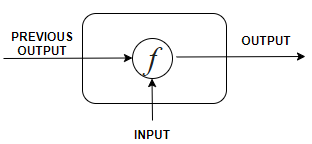

Within the model we apply several auxilary layers:

* [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. 
* [SpatialDropout1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SpatialDropout1D) performs the same function but drops the entire 1D features maps instead of individual elements.

We will apply *ReLU* as the activation function to the RNN layer. The function will output the input directly if it is positive, otherwise, it will output zero. The math formula:

$$ y = max(0, x) $$

We apply *RMSProp* which is the gradient based optimizer. The idea behind it is to:
* maintain a moving average of the square of gradients
* divide the gradient by the root of this average

Tha math formula:

$$ E[g^2]_t = \beta E[g^2]_{t-1} + (1 - \beta)(\frac{\delta C}{\delta w}) $$

$$ w_t = w_{t-1} - \frac{\eta}{\sqrt{E[g^2]_t} \frac{\delta C}{\delta w}}$$
where:
$ E[g] $ - moving average of squarred gradients

The *loss function* applied is the cross-entropy loss, or log loss, which measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. The math formula:

$$ CE = - \Sigma^C_i t_i*log(s_i) $$  
where:

$ t_i $ is the groundtruth

$ s_i $ is the model prediction

$ i $ is a label

$ C $ is the number of labels

In [ ]:
model = Sequential()
# convert each word index into multidimensial vector
model.add(Embedding(maxWordsCount, 5, input_length=xLen))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(SimpleRNN(
    5, # units: dimensionality of the output space
    dropout=0.2, # drop within the linear transformation of the inputs
    recurrent_dropout=0.2, # drop within the linear transformation of the recurrent state
    activation='relu'
))
model.add(Dense(nLabels, activation='softmax'))

model.compile(
    optimizer = 'rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    xTrain, yTrain,
    epochs=8,
    batch_size=512,
    validation_data=(xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
pred = recognizeMultiLabels(model, xTestLabels, 'Dense')

The result is really low. The next to test will be [GRU](https://keras.io/api/layers/recurrent_layers/gru/) layer. Compared to the SimpleRNN it adds an *Update Gate* and *Reset Gate* which are to decide how much to forget and how much to remember:

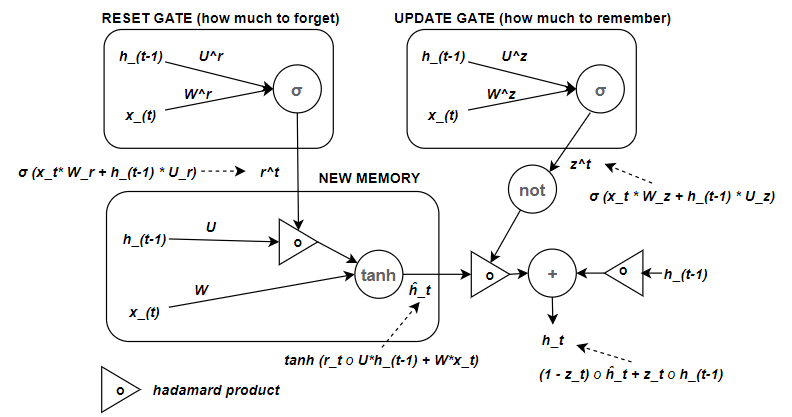

$ h $ - previous output with the weight of $ U $

$ x $ - input with the weight of $ W $



In [ ]:
model = Sequential()
model.add(Embedding(maxWordsCount, 5, input_length=xLen))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(GRU(
    5,
    dropout=0.2,
    recurrent_dropout=0.2,
    activation='relu'
))
model.add(Dense(nLabels, activation='softmax'))

model.compile(
    optimizer = 'rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    xTrain, yTrain,
    epochs=8,
    batch_size=512,
    validation_data=(xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
pred = recognizeMultiLabels(model, xTestLabels, 'GRU')

Obviously, GRU doesn't work here. Let's give a try to [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) - this layer differes from *GRU* by an additional gate - the input gate:

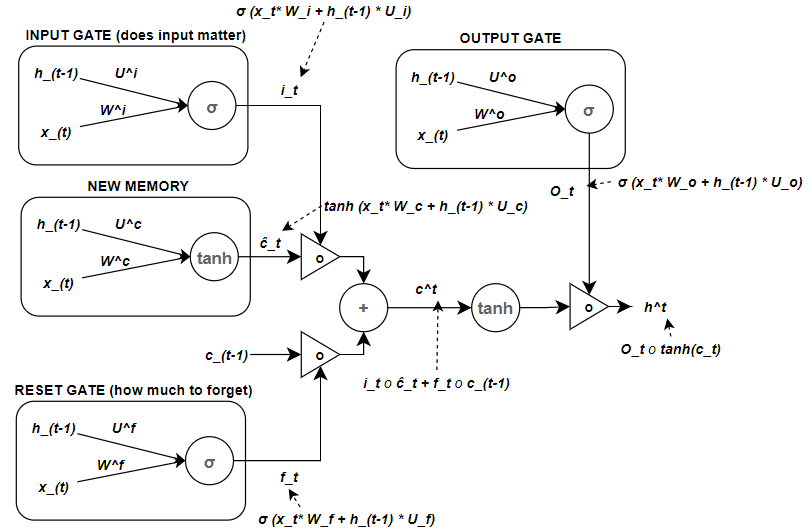

Some points on the difference between GRU and LSTM:
* GRU passes memory directly to the next unit without any control
* LSTM controlls memory by the output gate

* GRU controls the info from the previous output by the reset gate
* LSTM uses reset gate independently to control the previous output info

In [ ]:
model = Sequential()
model.add(Embedding(maxWordsCount, 5, input_length=xLen))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(LSTM(4))
model.add(Dense(nLabels, activation='softmax'))

model.compile(
    optimizer = 'rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    xTrain, yTrain,
    epochs=8,
    batch_size=512,
    validation_data=(xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
pred = recognizeMultiLabels(model, xTestLabels, 'LSTM')

The model starts to differentiate the labels, but the score is too low. Keras LSTM has the option to play within the layers - either to return the last output or the full sequence. We'll try the latter:

In [ ]:
model = Sequential()
model.add(Embedding(maxWordsCount, 5, input_length=xLen))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(LSTM(4, return_sequences=True))
model.add(LSTM(4))
model.add(Dense(nLabels, activation='softmax'))

model.compile(
    optimizer = 'rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    xTrain, yTrain,
    epochs=8,
    batch_size=512,
    validation_data=(xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
pred = recognizeMultiLabels(model, xTestLabels, 'LSTM, return sequences')

The model still cannot catch the dependency. Another structure to try - LSTM plus Dense hidden layers:

In [ ]:
model = Sequential()
model.add(Embedding(maxWordsCount, 5, input_length=xLen))
model.add(SpatialDropout1D(0.4))
model.add(BatchNormalization())
model.add(LSTM(4, return_sequences=True))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(nLabels, activation='softmax'))

model.compile(
    optimizer = 'rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    xTrain, yTrain,
    epochs=8,
    batch_size=512,
    validation_data=(xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
pred = recognizeMultiLabels(model, xTestLabels, 'LSTM + Dense')

Keras allows to implement the *bidirectional* LSTM-s, i.e. to train two instead of one LSTM on the input sequence. This allow to increase the amount of input info avaialble to the network.

In [ ]:
model = Sequential()
model.add(Embedding(maxWordsCount, 5, input_length=xLen))
model.add(SpatialDropout1D(0.3))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(GRU(16, return_sequences=True, reset_after=True)) # reset gate after the matrices multiplication
model.add(GRU(16, reset_after=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(nLabels, activation='softmax'))

model.compile(
    optimizer = 'rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    xTrain, yTrain,
    epochs=8,
    batch_size=512,
    validation_data=(xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
pred = recognizeMultiLabels(model, xTestLabels, 'LSTM + Dense')

## CONVOLUTIONAL NN FOR TEXTS

Convolutional NN re considered to be quite a fit for the NLP tasks. We'll implement the model with [one-dimensional convolutional layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) from Keras. 

An additional layers we use is the *MaxPooling* layer. This helps us to avoid overfitting by reducing the dimensionality by applying max filter to the subregions of the initial representation. For example let's take 2 dimensional input - a 4x4 matrix with a filter 2x2 and the filter's step 2:

8|12|3|4
-|-|-|-
3|11|1|2
10|2|3|5
82|21|54|47

By applying *MaxPooling2D* we get:

12|4
-|-
82|54



In [ ]:
model = Sequential()
model.add(Embedding(maxWordsCount, 5, input_length=xLen))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(Conv1D(
    filters = 20, # number of output filters in the convolution
    kernel_size = 5, # length of a filter
    activation='relu'
))
model.add(Conv1D(
    filters = 20,
    kernel_size = 5,
    activation='relu'
))
model.add(MaxPooling1D(2)) # stride 2
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(nLabels, activation='softmax'))

model.compile(
    optimizer = 'rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    xTrain, yTrain,
    epochs=20,
    batch_size=200,
    validation_data=(xTest, yTest)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

xTestLabels, xTestLabelsB = createTestMultiClasses(testWordIndices, xLen, step)
pred = recognizeMultiLabels(model, xTestLabels, 'Convolution1D')

For this dataset and preprocessing steps the convolutional layers are much better compared to the recurrent ones, but still the score is far from the sufficient value.